In [1]:
import pandas as pd
import numpy as np
import os
import re
import warnings
from tqdm import tqdm
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [19]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import pickle

In [4]:
# CONSTANTS
EXTERNAL_DATA_PATH = "../data/external"
DESTINATION_DATA_PATH = "../data/preprocessed"
ARTIFACTS_PATH = "../bin"
SEED = 42
test_size = 0.15


np.random.seed(SEED)

In [5]:
def reduce_memory_usage(df:pd.DataFrame) -> pd.DataFrame:
        numerics = ['int8', 'int16', 'int32', 'int64', 'float8','float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2    
        for col in tqdm(df.columns):
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if (c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max) or (c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max):
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if (c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max) or (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
        end_mem = df.memory_usage().sum() / 1024**2
        print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
        return df

In [6]:
df = reduce_memory_usage(pd.read_csv(os.path.join(EXTERNAL_DATA_PATH, "train.csv"), engine = "pyarrow"))
df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 399.30it/s]


Mem. usage decreased to  0.09 Mb (72.6% reduction)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int16  
 1   blue           2000 non-null   int16  
 2   clock_speed    2000 non-null   float32
 3   dual_sim       2000 non-null   int16  
 4   fc             2000 non-null   int16  
 5   four_g         2000 non-null   int16  
 6   int_memory     2000 non-null   int16  
 7   m_dep          2000 non-null   float32
 8   mobile_wt      2000 non-null   int16  
 9   n_cores        2000 non-null   int16  
 10  pc             2000 non-null   int16  
 11  px_height      2000 non-null   int16  
 12  px_width       2000 non-null   int16  
 13  ram            2000 non-null   int16  
 14  sc_h           2000 non-null   int16  
 15  sc_w           2000 non-null   int16  
 16  talk_time      2000 non-null   int16  
 17  three_g        2000 non-null   int16  
 18  touch_sc

In [8]:
# make sure no duplication....
df.duplicated().sum()

0

In [9]:
# suggested Feature Engineering..
df["cpu_interaction"] = df["clock_speed"] * df["n_cores"]
df["camera_interaction"] = df["pc"] + df["fc"]
df["px_interaction"] = df["px_height"]*df["px_width"]
df["sc_interaction"] = df["sc_h"]*df["sc_w"]
df["g_interaction"] = df["three_g"] + df["four_g"]
df["capabilities_interaction"] = df["wifi"]+df["touch_screen"]+df["blue"]+df["dual_sim"]+df["g_interaction"]

In [10]:
# selecting best features, based on mutual info score.....
def select_best_features(X, y, thresh:float=0.01):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name = "MI-Scores", index = X.columns)
    mi_scores.sort_values(ascending = False)
    mi_scores = mi_scores[mi_scores>0.01]
    return list(mi_scores.index)

In [11]:
X,y = df.drop("price_range", axis = 1), df["price_range"]
best_features = select_best_features(X, y)
best_features

['battery_power',
 'fc',
 'int_memory',
 'mobile_wt',
 'n_cores',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'camera_interaction',
 'sc_interaction',
 'g_interaction']

In [12]:
# search space of GB Classifier
SEARCH_SPACE={
    "n_estimators":scope.int(hp.quniform("n_estimators", 20, 700, 5)),
    "max_depth":scope.int(hp.quniform("max_depth", 1, 12, 1)),
    "min_samples_split":scope.int(hp.quniform("num_leaves", 100, 150, 5)),
    "min_samples_leaf":scope.int(hp.quniform("min_samples_leaf", 30, 500, 20)),
    "learning_rate":scope.float(hp.quniform("learning_rate", 0.01, 0.3, 0.001))
}

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X[best_features], y, test_size = 0.15, random_state = SEED)

In [14]:
def optimize(params):
    booster = GradientBoostingClassifier(**params)
    booster.fit(X_train, y_train)
    y_pred_probs = booster.predict_proba(X_valid)
    y_pred = booster.predict(X_valid)
    auc_roc = -1*roc_auc_score(y_valid, y_pred_probs, multi_class = "ovr")
    f1 = -1*f1_score(y_valid, y_pred, average = "micro")
    #cm = confusion_matrix(y_valid, y_pred)
    print(f"AUC-ROC: {auc_roc}")
    print(f"F1-SCORE: {f1}")
    return {"loss":auc_roc, "status":STATUS_OK}

In [15]:
trails = Trials()
best_res = fmin(
    fn = optimize,
    space = SEARCH_SPACE,
    algo = tpe.suggest,
    max_evals=5,
    trials=trails
)

AUC-ROC: -0.990305580515126                                                                                        
F1-SCORE: -0.9166666666666666                                                                                      
AUC-ROC: -0.9799255050055733                                                                                       
F1-SCORE: -0.87                                                                                                    
AUC-ROC: -0.9931591724264638                                                                                       
F1-SCORE: -0.9266666666666666                                                                                      
AUC-ROC: -0.9759443568612893                                                                                       
F1-SCORE: -0.8566666666666667                                                                                      
AUC-ROC: -0.9943893037883911                                            

In [16]:
best_res

{'learning_rate': 0.092,
 'max_depth': 11.0,
 'min_samples_leaf': 240.0,
 'n_estimators': 405.0,
 'num_leaves': 120.0}

In [18]:
params = {'learning_rate': 0.092,'max_depth': 11,'min_samples_leaf': 240,'n_estimators': 405,'min_samples_split': 120}
booster = GradientBoostingClassifier(**params)
booster.fit(X[best_features], y)

GradientBoostingClassifier(learning_rate=0.092, max_depth=11,
                           min_samples_leaf=240, min_samples_split=120,
                           n_estimators=405)

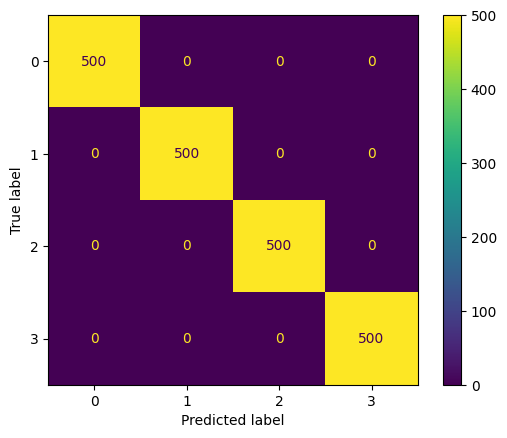

In [25]:
import matplotlib.pyplot as plt
preds = booster.predict(X[best_features])
cm = confusion_matrix(y, preds, labels = y.unique())
ConfusionMatrixDisplay.from_predictions(y, preds)
plt.show()

In [26]:
test_df = reduce_memory_usage(pd.read_csv(os.path.join(EXTERNAL_DATA_PATH, "test.csv"), engine = "pyarrow"))
test_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 168.00it/s]


Mem. usage decreased to  0.04 Mb (72.6% reduction)


,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [27]:
test_df["cpu_interaction"] = test_df["clock_speed"] * test_df["n_cores"]
test_df["camera_interaction"] = test_df["pc"] + test_df["fc"]
test_df["px_interaction"] = test_df["px_height"]*test_df["px_width"]
test_df["sc_interaction"] = test_df["sc_h"]*test_df["sc_w"]
test_df["g_interaction"] = test_df["three_g"] + test_df["four_g"]
test_df["capabilities_interaction"] = test_df["wifi"]+test_df["touch_screen"]+test_df["blue"]+test_df["dual_sim"]+test_df["g_interaction"]

In [28]:
test_preds = booster.predict(test_df[best_features])
test_preds

array([3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2, 1, 3,
       2, 1, 3, 0, 2, 0, 2, 0, 2, 0, 3, 0, 1, 1, 3, 1, 2, 1, 1, 2, 0, 0,
       0, 1, 0, 3, 1, 2, 1, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 2, 0, 1, 1, 1,
       1, 3, 1, 2, 1, 2, 2, 3, 3, 0, 2, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1,
       3, 0, 1, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 0, 0, 3, 1, 2, 0, 1, 2, 3,
       3, 3, 1, 3, 3, 3, 3, 2, 3, 0, 0, 3, 2, 1, 1, 0, 3, 2, 3, 1, 0, 2,
       1, 1, 3, 1, 1, 0, 3, 2, 1, 2, 1, 2, 2, 3, 3, 2, 2, 3, 2, 3, 1, 0,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 1, 2, 1, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 1, 0, 3, 2, 0, 2, 2,
       2, 3, 1, 2, 3, 2, 3, 2, 2, 1, 0, 0, 1, 3, 0, 2, 3, 3, 0, 2, 0, 3,
       2, 3, 3, 1, 0, 1, 0, 3, 0, 1, 0, 2, 2, 1, 3, 1, 3, 0, 3, 1, 2, 0,
       0, 2, 1, 3, 2, 3, 1, 1, 3, 0, 0, 2, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2,
       3, 3, 3, 1, 0, 1, 2, 3, 1, 1, 3, 2, 0, 3, 0, 0, 2, 0, 0, 3, 2, 3,
       3, 2, 1, 3, 3, 2, 3, 2, 2, 1, 2, 0, 2, 3, 1,